## Stochastic Gradient Hamiltonian Monte Carlo
### multi-dimensional random variable, optimization using Cython

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [21]:
def sghmc_vector(U, gradU, m, dt, nstep, x, C, V): # this is sigficantly slower than the scalar one.
    mean = np.zeros_like(x)
    p = np.random.multivariate_normal(mean, m)
    B = 0.5 * dt * V
    D = 2. * (C-B) * dt
    for i in range(nstep):
        p += -gradU(x) * dt - C.dot( np.linalg.solve(m, p)) * dt + np.random.multivariate_normal(mean, D)
        x += np.linalg.solve(m, p) * dt
    return x.copy()

In [2]:
%load_ext cython

In [27]:
%%cython --annotate
cimport cython
import numpy as np

@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:] gradU_vector(double[:] x):
    cdef double[:] mean = np.zeros_like(x)
    cdef double[:,:] var = np.array([[4.]])
    cdef double[:] MultiVarNormal = np.random.multivariate_normal(mean, var)
    cdef int i
    cdef double[:] grad = np.zeros_like(x)
    for i in range(len(x)):
        grad[i] = -4 * x[i] + 4 * x[i]**3 + MultiVarNormal[i]
    return grad



@cython.wraparound(False)
@cython.boundscheck(False)
cdef double[:] MatVec_multiply(double[:,:] u, double[:] v):
    '''matrix multiply, for the gradient descent function below'''
    cdef int i, k
    cdef int m, n
    cdef double[:] res
    
    m = u.shape[0]
    n = u.shape[1]
    res = np.zeros(m)

    for i in range(m):
        for k in range(n):
            res[i] += u[i,k] * v[k]
    return res

@cython.wraparound(False)
@cython.boundscheck(False)
def sghmc_vector_cython(double[:,:] m, double dt, int nstep, double[:] x, double[:,:] C, double[:,:] V): 
    cdef int i
    cdef int j
    cdef int k
    cdef double[:] mean = np.zeros_like(x)
    cdef double[:] p = np.random.multivariate_normal(mean, m)
    
    cdef double[:,:] B = np.zeros_like(V)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            B[i,j] = 0.5 * dt * V[i,j]
    
    cdef double[:,:] D = np.zeros_like(C)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            D[i,j] = 2 * (C[i,j] - B[i,j]) *dt
    
    cdef double[:] MultiVarNormal
    cdef double[:] Cmp
    cdef double[:] gradx
    for i in range(nstep):
        MultiVarNormal = np.random.multivariate_normal(mean, D)
        Cmp = np.linalg.solve(m, p)
        Cmp = MatVec_multiply(C, Cmp)
        gradx = gradU_vector(x)
        for j in range(len(p)):
            p[j] += -1 * gradx[j] * dt - Cmp[j] * dt + MultiVarNormal[j]
        Cmp = np.linalg.solve(m, p)
        for k in range(len(x)):
            x[k] += Cmp[k] * dt
    return x
        
    

In [13]:
def U(x):
    return -2. * x**2 + x**4

def gradU_vector(x):
    mean = np.zeros_like(x)
    return -4. * x + 4. * x**3 + np.random.multivariate_normal(mean, np.array([[4.]]))

def gradU_perfect(x):
    return -4. * x + 4. * x**3

In [14]:
nsample = 8000
xStep = 0.1
m = np.array([[1.]])
C = np.array([[3.]])
dt = 0.1
nstep = 50
V = np.array([[4.]])

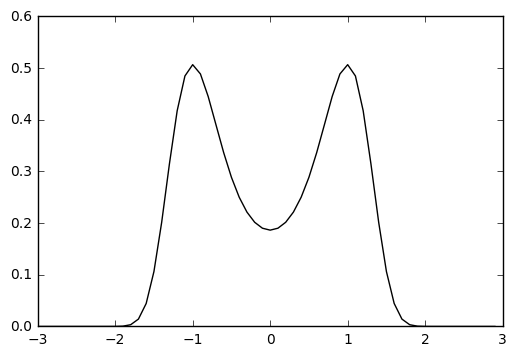

In [15]:
xGrid = np.arange(-3., 3., xStep)
y = np.exp( - U(xGrid) )
y = y / (np.sum(y) * xStep)
plt.plot(xGrid,y, '-k')

In [22]:
x = np.array([0.])

In [24]:
%timeit -n2 -r4 sghmc_vector(U, gradU_vector, m, dt, nstep, x, C, V)

2 loops, best of 4: 18.4 ms per loop


### Using simple python version sghmc_vector

In [ ]:
samples = np.zeros(nsample)
x = np.array([0.])
for i in range(nsample):
    samples[i] = sghmc_vector( U, gradU_vector, m, dt, nstep, x.copy(), C, V )[0]

In [ ]:
yshmc = scipy.stats.histogram(samples, numbins=len(xGrid), defaultlimits=(-3.,3.))[0]
yshmc = yshmc / (np.sum(yshmc) * xStep)

In [ ]:
plt.plot(xGrid,yshmc, '.-r', label='SGHMC')
plt.plot(xGrid,y, '-k', label='True Distribution')
plt.ylim(0.0,0.8)
plt.legend()

### Using sghmc_vector_cython

In [18]:
samples = np.zeros(nsample)
x = np.array([0.])
for i in range(nsample):
    samples[i] = sghmc_vector_cython( m, dt, nstep, x.copy(), C, V )[0]

In [19]:
yshmc = scipy.stats.histogram(samples, numbins=len(xGrid), defaultlimits=(-3.,3.))[0]
yshmc = yshmc / (np.sum(yshmc) * xStep)

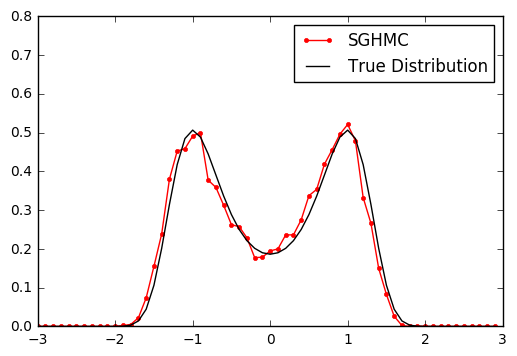

In [20]:
plt.plot(xGrid,yshmc, '.-r', label='SGHMC')
plt.plot(xGrid,y, '-k', label='True Distribution')
plt.ylim(0.0,0.8)
plt.legend()

In [28]:
x = np.array([0.])

In [29]:
%timeit -n2 -r4 sghmc_vector_cython( m, dt, nstep, x, C, V)

2 loops, best of 4: 19.9 ms per loop
